<a href="https://colab.research.google.com/github/geraldy-christanto/UAS/blob/master/FakeNewsDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import csv
import numpy as np
import nltk
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import seaborn as sb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import nltk.corpus 
from gensim.models.word2vec import Word2Vec
nltk.download('treebank')
import pickle
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import  LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import sklearn.metrics as metrics


[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


In [0]:
test_filename = 'https://raw.githubusercontent.com/geraldy-christanto/UAS/master/test.csv'
train_filename = 'https://raw.githubusercontent.com/geraldy-christanto/UAS/master/train.csv'
valid_filename = 'https://raw.githubusercontent.com/geraldy-christanto/UAS/master/valid.csv'

train_news = pd.read_csv(train_filename)
test_news = pd.read_csv(test_filename)
valid_news = pd.read_csv(valid_filename)

In [0]:
#data observation
def data_obs():
    print("training dataset size:")
    print(train_news.shape)
    print(train_news.head(10))

    #below dataset were used for testing and validation purposes
    print(test_news.shape)
    print(test_news.head(10))
    
    print(valid_news.shape)
    print(valid_news.head(10))

In [4]:
data_obs()

training dataset size:
(10240, 2)
                                           Statement  Label
0  Says the Annies List political group supports ...  False
1  When did the decline of coal start? It started...   True
2  Hillary Clinton agrees with John McCain "by vo...   True
3  Health care reform legislation is likely to ma...  False
4  The economic turnaround started at the end of ...   True
5  The Chicago Bears have had more starting quart...   True
6  Jim Dunnam has not lived in the district he re...  False
7  I'm the only person on this stage who has work...   True
8  However, it took $19.5 million in Oregon Lotte...   True
9  Says GOP primary opponents Glenn Grothman and ...   True
(2551, 2)
                                           Statement  Label
0  Building a wall on the U.S.-Mexico border will...   True
1  Wisconsin is on pace to double the number of l...  False
2  Says John McCain has done nothing to help the ...  False
3  Suzanne Bonamici supports a plan that will cut...   T

In [0]:
def create_distribution(dataFile):
    
    return sb.countplot(x='Label', data=dataFile, palette='hls')

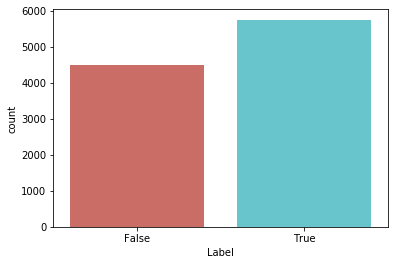

In [6]:
create_distribution(train_news)

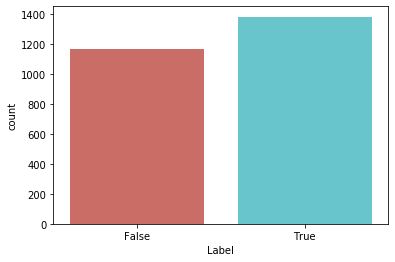

In [7]:
create_distribution(test_news)

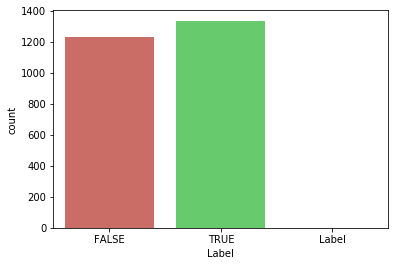

In [8]:
create_distribution(valid_news)

In [0]:
def data_qualityCheck():
    
    print("Checking data qualitites...")
    train_news.isnull().sum()
    train_news.info()
        
    print("check finished.")

    #below datasets were used to 
    test_news.isnull().sum()
    test_news.info()

    valid_news.isnull().sum()
    valid_news.info()

In [10]:
data_qualityCheck()

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 2 columns):
Statement    10240 non-null object
Label        10240 non-null bool
dtypes: bool(1), object(1)
memory usage: 90.1+ KB
check finished.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2551 entries, 0 to 2550
Data columns (total 2 columns):
Statement    2551 non-null object
Label        2551 non-null bool
dtypes: bool(1), object(1)
memory usage: 22.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2571 entries, 0 to 2570
Data columns (total 2 columns):
Statement    2571 non-null object
Label        2569 non-null object
dtypes: object(2)
memory usage: 40.3+ KB


In [0]:
#Stemming
def stem_tokens(tokens, stemmer):
    stemmed = []
    for token in tokens:
        stemmed.append(stemmer.stem(token))
    return stemmed

#process the data
def process_data(data,exclude_stopword=True,stem=True):
    tokens = [w.lower() for w in data]
    tokens_stemmed = tokens
    tokens_stemmed = stem_tokens(tokens, eng_stemmer)
    tokens_stemmed = [w for w in tokens_stemmed if w not in stopwords ]
    return tokens_stemmed


#creating ngrams
#unigram 
def create_unigram(words):
    assert type(words) == list
    return words

#bigram
def create_bigrams(words):
    assert type(words) == list
    skip = 0
    join_str = " "
    Len = len(words)
    if Len > 1:
        lst = []
        for i in range(Len-1):
            for k in range(1,skip+2):
                if i+k < Len:
                    lst.append(join_str.join([words[i],words[i+k]]))
    else:
        #set it as unigram
        lst = create_unigram(words)
    return lst

In [0]:
porter = PorterStemmer()

In [0]:
def tokenizer(text):
    return text.split()


def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]


In [0]:
countV = CountVectorizer()
train_count = countV.fit_transform(train_news['Statement'].values)

In [15]:
print(countV)
print(train_count)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)
  (0, 9676)	1
  (0, 10988)	1
  (0, 1044)	1
  (0, 6639)	1
  (0, 8376)	1
  (0, 5115)	1
  (0, 10709)	1
  (0, 11036)	1
  (0, 11296)	1
  (0, 615)	1
  (0, 7728)	1
  (0, 3278)	1
  (1, 10988)	1
  (1, 11934)	2
  (1, 3434)	1
  (1, 3185)	1
  (1, 7672)	1
  (1, 2475)	1
  (1, 10425)	1
  (1, 6052)	1
  (1, 10426)	2
  (1, 7418)	1
  (1, 4860)	1
  (1, 11138)	1
  (1, 7674)	1
  :	:
  (10239, 10988)	1
  (10239, 7672)	2
  (10239, 11110)	2
  (10239, 5267)	1
  (10239, 7828)	1
  (10239, 7824)	1
  (10239, 1159)	1
  (10239, 12151)	2
  (10239, 6327)	1
  (10239, 6603)	1
  (10239, 11013)	1
  (10239, 11004)	1


In [0]:
def get_countVectorizer_stats():
    
    #vocab size
    train_count.shape

    #check vocabulary using below command
    print(countV.vocabulary_)

    #get feature names
    print(countV.get_feature_names()[:25])


#create tf-df frequency features
#tf-idf 
tfidfV = TfidfTransformer()
train_tfidf = tfidfV.fit_transform(train_count)

def get_tfidf_stats():
    train_tfidf.shape
    #get train data feature names 
    print(train_tfidf.A[:10])

In [0]:
tfidf_ngram = TfidfVectorizer(stop_words='english',ngram_range=(1,4),use_idf=True,smooth_idf=True)

In [18]:
#POS Tagging
tagged_sentences = nltk.corpus.treebank.tagged_sents()

cutoff = int(.75 * len(tagged_sentences))
training_sentences = train_news['Statement']
 
print(training_sentences)

0        Says the Annies List political group supports ...
1        When did the decline of coal start? It started...
2        Hillary Clinton agrees with John McCain "by vo...
3        Health care reform legislation is likely to ma...
4        The economic turnaround started at the end of ...
                               ...                        
10235    There are a larger number of shark attacks in ...
10236    Democrats have now become the party of the [At...
10237    Says an alternative to Social Security that op...
10238    On lifting the U.S. Cuban embargo and allowing...
10239    The Department of Veterans Affairs has a manua...
Name: Statement, Length: 10240, dtype: object


In [0]:
def features(sentence, index):
    """ sentence: [w1, w2, ...], index: the index of the word """
    return {
        'word': sentence[index],
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'is_all_caps': sentence[index].upper() == sentence[index],
        'is_all_lower': sentence[index].lower() == sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'prev_word': '' if index == 0 else sentence[index - 1],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1],
        'has_hyphen': '-' in sentence[index],
        'is_numeric': sentence[index].isdigit(),
        'capitals_inside': sentence[index][1:].lower() != sentence[index][1:]
    }

In [0]:
def untag(tagged_sentence):
    return [w for w, t in tagged_sentence]

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Using Word2Vec 
with open("/content/drive/My Drive/glove.6B.50d.txt", "rb") as lines:
    w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
           for line in lines}

In [0]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.itervalues().next())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [0]:
doc_new = ['obama is running for president in 2016']

In [25]:
#building classifier using naive bayes
nb_pipeline = Pipeline([
        ('NBCV',countV),
        ('nb_clf',MultinomialNB())])

nb_pipeline.fit(train_news['Statement'],train_news['Label'])
predicted_nb = nb_pipeline.predict(test_news['Statement'])
np.mean(predicted_nb == test_news['Label'])


0.6072128577028616

In [26]:
#building classifier using logistic regression
logR_pipeline = Pipeline([
        ('LogRCV',countV),
        ('LogR_clf',LogisticRegression())
        ])

logR_pipeline.fit(train_news['Statement'],train_news['Label'])
predicted_LogR = logR_pipeline.predict(test_news['Statement'])
np.mean(predicted_LogR == test_news['Label'])


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5985887887103096

In [27]:
#building Linear SVM classfier
svm_pipeline = Pipeline([
        ('svmCV',countV),
        ('svm_clf',svm.LinearSVC())
        ])

svm_pipeline.fit(train_news['Statement'],train_news['Label'])
predicted_svm = svm_pipeline.predict(test_news['Statement'])
np.mean(predicted_svm == test_news['Label'])


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5723245785966288

In [28]:
#using SVM Stochastic Gradient Descent on hinge loss
sgd_pipeline = Pipeline([
        ('svm2CV',countV),
        ('svm2_clf',SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3))#, n_iter=5))
        ])

sgd_pipeline.fit(train_news['Statement'],train_news['Label'])
predicted_sgd = sgd_pipeline.predict(test_news['Statement'])
np.mean(predicted_sgd == test_news['Label'])


0.6127009016072129

In [29]:
#random forest
random_forest = Pipeline([
        ('rfCV',countV),
        ('rf_clf',RandomForestClassifier(n_estimators=200,n_jobs=3))
        ])
    
random_forest.fit(train_news['Statement'],train_news['Label'])
predicted_rf = random_forest.predict(test_news['Statement'])
np.mean(predicted_rf == test_news['Label'])

0.6256370050960408

In [0]:
def build_confusion_matrix(classifier):
    
    k_fold = KFold(n_splits=5)
    scores = []
    confusion = np.array([[0,0],[0,0]])

    for train_ind, test_ind in k_fold.split(train_news):
        train_text = train_news.iloc[train_ind]['Statement'] 
        train_y = train_news.iloc[train_ind]['Label']
    
        test_text = train_news.iloc[test_ind]['Statement']
        test_y = train_news.iloc[test_ind]['Label']
        
        classifier.fit(train_text,train_y)
        predictions = classifier.predict(test_text)
        
        confusion += confusion_matrix(test_y,predictions)
        score = f1_score(test_y,predictions)
        scores.append(score)
    
    return (print('Total statements classified:', len(train_news)),print('Score:', sum(scores)/len(scores)),print('score length', len(scores)),print('Confusion matrix:'),print(confusion))

In [31]:
#K-fold cross validation for all classifiers
build_confusion_matrix(nb_pipeline)
build_confusion_matrix(logR_pipeline)
build_confusion_matrix(svm_pipeline)
build_confusion_matrix(sgd_pipeline)
build_confusion_matrix(random_forest)


Total statements classified: 10240
Score: 0.66961153965076
score length 5
Confusion matrix:
[[2118 2370]
 [1664 4088]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Total statements classified: 10240
Score: 0.6469090977975251
score length 5
Confusion matrix:
[[2252 2236]
 [1933 3819]]
Total statements classified: 10240
Score: 0.6104687487924283
score length 5
Confusion matrix:
[[2260 2228]
 [2246 3506]]
Total statements classified: 10240
Score: 0.6628038952134204
score length 5
Confusion matrix:
[[2173 2315]
 [1753 3999]]
Total statements classified: 10240
Score: 0.6999255083801291
score length 5
Confusion matrix:
[[1798 2690]
 [1207 4545]]


(None, None, None, None, None)

In [32]:
#naive-bayes classifier
nb_pipeline_ngram = Pipeline([
        ('nb_tfidf',tfidf_ngram),
        ('nb_clf',MultinomialNB())])

nb_pipeline_ngram.fit(train_news['Statement'],train_news['Label'])
predicted_nb_ngram = nb_pipeline_ngram.predict(test_news['Statement'])
np.mean(predicted_nb_ngram == test_news['Label'])


0.5938847510780086

In [33]:
#logistic regression classifier
logR_pipeline_ngram = Pipeline([
        ('LogR_tfidf',tfidf_ngram),
        ('LogR_clf',LogisticRegression(penalty="l2",C=1))
        ])

logR_pipeline_ngram.fit(train_news['Statement'],train_news['Label'])
predicted_LogR_ngram = logR_pipeline_ngram.predict(test_news['Statement'])
np.mean(predicted_LogR_ngram == test_news['Label'])


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6193649549196394

In [34]:
#linear SVM classifier
svm_pipeline_ngram = Pipeline([
        ('svm_tfidf',tfidf_ngram),
        ('svm_clf',svm.LinearSVC())
        ])

svm_pipeline_ngram.fit(train_news['Statement'],train_news['Label'])
predicted_svm_ngram = svm_pipeline_ngram.predict(test_news['Statement'])
np.mean(predicted_svm_ngram == test_news['Label'])


0.6170129361034888

In [35]:
#sgd classifier
sgd_pipeline_ngram = Pipeline([
         ('sgd_tfidf',tfidf_ngram),
         ('sgd_clf',SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3))#, n_iter=5))
         ])

sgd_pipeline_ngram.fit(train_news['Statement'],train_news['Label'])
predicted_sgd_ngram = sgd_pipeline_ngram.predict(test_news['Statement'])
np.mean(predicted_sgd_ngram == test_news['Label'])


0.5417483339866719

In [36]:
#random forest classifier
random_forest_ngram = Pipeline([
        ('rf_tfidf',tfidf_ngram),
        ('rf_clf',RandomForestClassifier(n_estimators=300,n_jobs=3))
        ])
    
random_forest_ngram.fit(train_news['Statement'],train_news['Label'])
predicted_rf_ngram = random_forest_ngram.predict(test_news['Statement'])
np.mean(predicted_rf_ngram == test_news['Label'])


0.6009408075264602

In [37]:
#K-fold cross validation for all classifiers
build_confusion_matrix(nb_pipeline_ngram)
build_confusion_matrix(logR_pipeline_ngram)
build_confusion_matrix(svm_pipeline_ngram)
build_confusion_matrix(sgd_pipeline_ngram)
build_confusion_matrix(random_forest_ngram)

Total statements classified: 10240
Score: 0.7224053159841455
score length 5
Confusion matrix:
[[ 758 3730]
 [ 390 5362]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Total statements classified: 10240
Score: 0.7044355553757985
score length 5
Confusion matrix:
[[1580 2908]
 [1043 4709]]
Total statements classified: 10240
Score: 0.6790920142902143
score length 5
Confusion matrix:
[[2016 2472]
 [1524 4228]]
Total statements classified: 10240
Score: 0.7190643331130575
score length 5
Confusion matrix:
[[   5 4483]
 [   6 5746]]
Total statements classified: 10240
Score: 0.6584902472696372
score length 5
Confusion matrix:
[[2028 2460]
 [1721 4031]]


(None, None, None, None, None)

In [38]:
print(classification_report(test_news['Label'], predicted_nb_ngram))
print(classification_report(test_news['Label'], predicted_LogR_ngram))
print(classification_report(test_news['Label'], predicted_svm_ngram))
print(classification_report(test_news['Label'], predicted_sgd_ngram))
print(classification_report(test_news['Label'], predicted_rf_ngram))

test_news['Label'].shape


              precision    recall  f1-score   support

       False       0.72      0.19      0.30      1169
        True       0.58      0.94      0.71      1382

    accuracy                           0.59      2551
   macro avg       0.65      0.56      0.51      2551
weighted avg       0.64      0.59      0.52      2551

              precision    recall  f1-score   support

       False       0.64      0.39      0.49      1169
        True       0.61      0.81      0.70      1382

    accuracy                           0.62      2551
   macro avg       0.62      0.60      0.59      2551
weighted avg       0.62      0.62      0.60      2551

              precision    recall  f1-score   support

       False       0.61      0.47      0.53      1169
        True       0.62      0.74      0.68      1382

    accuracy                           0.62      2551
   macro avg       0.61      0.61      0.60      2551
weighted avg       0.62      0.62      0.61      2551

              preci

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(2551,)

In [39]:
#random forest classifier parameters
parameters = {'rf_tfidf__ngram_range': [(1, 1), (1, 2),(1,3),(1,4),(1,5)],
               'rf_tfidf__use_idf': (True, False),
               'rf_clf__max_depth': (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15)
}

gs_clf = GridSearchCV(random_forest_ngram, parameters, cv = 5,n_jobs=-1)
gs_clf = gs_clf.fit(train_news['Statement'][:10000],train_news['Label'][:10000])

gs_clf.best_score_
gs_clf.best_params_
gs_clf.cv_results_


{'mean_fit_time': array([1.44522519, 1.45280347, 2.00289917, 2.05517449, 2.70621552,
        2.70797501, 3.21074286, 3.20161653, 3.71105342, 3.65221953,
        1.55888376, 1.52821884, 2.12656016, 2.08620768, 2.70102754,
        2.74913907, 3.27527156, 3.25638142, 3.82633152, 3.74545841,
        1.52770467, 1.51513839, 2.1823092 , 2.18321729, 2.88461342,
        2.89950986, 3.55865016, 3.48363504, 4.0642993 , 4.05136728,
        1.67994652, 1.6698432 , 2.35463018, 2.35802026, 3.34158425,
        3.22386603, 3.91261258, 3.83141842, 4.34665079, 4.37040997,
        1.77482953, 1.75852513, 2.62061381, 2.6524374 , 3.41002679,
        3.26902924, 4.11433806, 4.01649036, 4.65645351, 4.7033947 ,
        1.82613435, 1.78859987, 2.57805157, 2.63869333, 3.58536744,
        3.40316763, 4.25863423, 4.25049944, 5.04684672, 5.01303053,
        1.92462149, 1.9005929 , 2.92457733, 2.88270917, 3.89758306,
        3.80754433, 4.62936511, 4.66252909, 5.31720667, 5.27568517,
        2.01258054, 1.97344222,

In [40]:
#logistic regression parameters
parameters = {'LogR_tfidf__ngram_range': [(1, 1), (1, 2),(1,3),(1,4),(1,5)],
               'LogR_tfidf__use_idf': (True, False),
               'LogR_tfidf__smooth_idf': (True, False)
}

gs_clf = GridSearchCV(logR_pipeline_ngram, parameters, n_jobs=-1, cv =5)
gs_clf = gs_clf.fit(train_news['Statement'][:10000],train_news['Label'][:10000])

gs_clf.best_score_
gs_clf.best_params_
gs_clf.cv_results_

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'mean_fit_time': array([0.30987101, 0.31218762, 0.30140657, 0.31972532, 0.8392282 ,
        0.82787614, 0.83281431, 0.82833428, 1.40323305, 1.43012357,
        1.3858079 , 1.39676566, 1.92544107, 1.99157376, 2.02432461,
        2.04153061, 2.46624751, 2.48336759, 2.49769158, 2.50699062]),
 'mean_score_time': array([0.06156387, 0.06345987, 0.06717682, 0.06357579, 0.0950635 ,
        0.09481058, 0.09632707, 0.0946589 , 0.11809182, 0.11938381,
        0.11846991, 0.11498966, 0.13902979, 0.14444785, 0.14610991,
        0.14263034, 0.18141475, 0.18340421, 0.19177799, 0.17684007]),
 'mean_test_score': array([0.6048, 0.6107, 0.6057, 0.6107, 0.6145, 0.6113, 0.6139, 0.6113,
        0.6148, 0.6108, 0.6166, 0.6108, 0.616 , 0.6099, 0.6159, 0.6099,
        0.6158, 0.6093, 0.6148, 0.6093]),
 'param_LogR_tfidf__ngram_range': masked_array(data=[(1, 1), (1, 1), (1, 1), (1, 1), (1, 2), (1, 2), (1, 2),
                    (1, 2), (1, 3), (1, 3), (1, 3), (1, 3), (1, 4), (1, 4),
                    (1, 4)

In [41]:
#Linear SVM 
parameters = {'svm_tfidf__ngram_range': [(1, 1), (1, 2),(1,3),(1,4),(1,5)],
               'svm_tfidf__use_idf': (True, False),
               'svm_tfidf__smooth_idf': (True, False),
               'svm_clf__penalty': ('l1','l2'),
}

gs_clf = GridSearchCV(svm_pipeline_ngram, parameters, n_jobs=-1, error_score = 0.0)
gs_clf = gs_clf.fit(train_news['Statement'][:10000],train_news['Label'][:10000])

gs_clf.best_score_
gs_clf.best_params_
gs_clf.cv_results_


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'mean_fit_time': array([0.22763205, 0.22783494, 0.22804832, 0.23547339, 0.65210358,
        0.62219405, 0.63386933, 0.62600851, 1.09362356, 1.05472573,
        1.09313329, 1.06199161, 1.51241803, 1.46047497, 1.51054049,
        1.45289119, 1.90548356, 1.8698678 , 1.88264179, 1.85707792,
        0.27998749, 0.2848413 , 0.27984643, 0.27675414, 0.71328672,
        0.68664924, 0.69999774, 0.70870352, 1.1987462 , 1.14599355,
        1.17830118, 1.14935573, 1.62496098, 1.57684127, 1.63485869,
        1.6112632 , 1.99587131, 1.91264121, 1.96652182, 1.91801842]),
 'mean_score_time': array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.09972342, 0.1001366 , 0.09987179, 0.09862598, 0.1547517 ,
        0.15589277, 0.15690486, 0.15774703, 0.19643251, 0.19691245,
        0.

In [42]:
#running both random forest and logistic regression models again with best parameter found with GridSearch method
random_forest_final = Pipeline([
        ('rf_tfidf',TfidfVectorizer(stop_words='english',ngram_range=(1,3),use_idf=True,smooth_idf=True)),
        ('rf_clf',RandomForestClassifier(n_estimators=300,n_jobs=3,max_depth=10))
        ])
    
random_forest_final.fit(train_news['Statement'],train_news['Label'])
predicted_rf_final = random_forest_final.predict(test_news['Statement'])
np.mean(predicted_rf_final == test_news['Label'])
print(metrics.classification_report(test_news['Label'], predicted_rf_final))


              precision    recall  f1-score   support

       False       1.00      0.00      0.00      1169
        True       0.54      1.00      0.70      1382

    accuracy                           0.54      2551
   macro avg       0.77      0.50      0.35      2551
weighted avg       0.75      0.54      0.38      2551



In [54]:
logR_pipeline_final = Pipeline([
        #('LogRCV',countV_ngram),
        ('LogR_tfidf',TfidfVectorizer(stop_words='english',ngram_range=(1,5),use_idf=True,smooth_idf=False)),
        ('LogR_clf',LogisticRegression(penalty="l2",C=1,solver='lbfgs'))
        ])

logR_pipeline_final.fit(train_news['Statement'],train_news['Label'])
predicted_LogR_final = logR_pipeline_final.predict(test_news['Statement'])
np.mean(predicted_LogR_final == test_news['Label'])
#accuracy
print(metrics.classification_report(test_news['Label'], predicted_LogR_final))


              precision    recall  f1-score   support

       False       0.64      0.38      0.48      1169
        True       0.61      0.82      0.70      1382

    accuracy                           0.62      2551
   macro avg       0.62      0.60      0.59      2551
weighted avg       0.62      0.62      0.60      2551



In [0]:
#saving best model to the disk
model_file = 'final_model.sav'
pickle.dump(logR_pipeline_ngram,open(model_file,'wb'))


In [0]:
#Plotting learing curve
def plot_learing_curve(pipeline,title):
    size = 10000
    cv = KFold(size, shuffle=True)
    
    X = train_news["Statement"]
    y = train_news["Label"]
    
    pl = pipeline
    pl.fit(X,y)
    
    train_sizes, train_scores, test_scores = learning_curve(pl, X, y, n_jobs=-1, cv=cv, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)
       
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
     
    plt.figure()
    plt.title(title)
    plt.legend(loc="best")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.gca().invert_yaxis()
    
    # box-like grid
    plt.grid()
    
    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    # sizes the window for readability and displays the plot
    # shows error from 0 to 1.1
    plt.ylim(-.1,1.1)
    plt.show()

In [0]:
def plot_learning_curve(pipeline,title,X,y, train_sizes=np.linspace(.1,1.0,5)):
    size = 100
 
    pl = pipeline
    pl.fit(X,y)
    
    cv = KFold(size, shuffle=True)   
    plt.figure()
    plt.title(title)
    plt.legend(loc="best")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(pl, X, y, n_jobs=-1, cv=cv, train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
     
    plt.gca().invert_yaxis()
    
    # box-like grid
    plt.grid()
    
    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    # sizes the window for readability and displays the plot
    # shows error from 0 to 1.1
    plt.ylim(-.1,1.1)
    plt.show()
    return plt


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
No handles with labels found to put in legend.


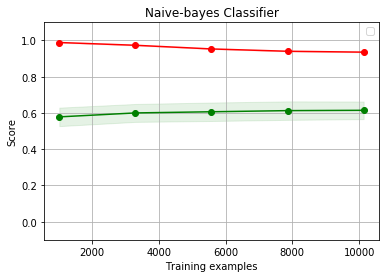

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [66]:
#below command will plot learing curves for each of the classifiers
X = train_news["Statement"]
y = train_news["Label"]
    
plot_learning_curve(logR_pipeline_ngram,"Naive-bayes Classifier", X,y)


In [0]:
plot_learing_curve(nb_pipeline_ngram,"LogisticRegression Classifier")

No handles with labels found to put in legend.


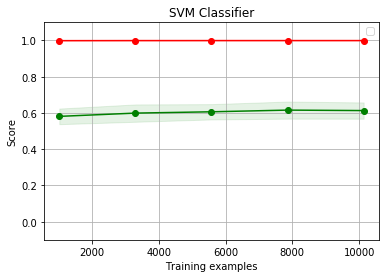

In [63]:
plot_learing_curve(svm_pipeline_ngram,"SVM Classifier")

No handles with labels found to put in legend.


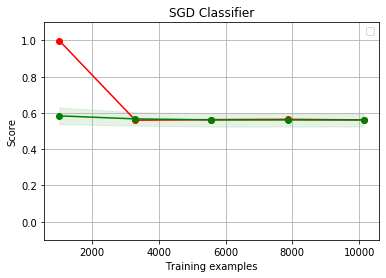

In [67]:
plot_learing_curve(sgd_pipeline_ngram,"SGD Classifier")

In [0]:
plot_learing_curve(random_forest_ngram,"RandomForest Classifier")

In [0]:
#plotting Precision-Recall curve
def plot_PR_curve(classifier):
    
    precision, recall, thresholds = precision_recall_curve(test_news['Label'], classifier)
    average_precision = average_precision_score(test_news['Label'], classifier)
    
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Random Forest Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))

In [0]:
plot_PR_curve(predicted_LogR_ngram)
plot_PR_curve(predicted_rf_ngram)